<h1>Gasoline Delivery Optimization Using Pyomo</h1>

Did you ever wonder how the gasoline you put in your car gets to the gas station?  In almost all cases, tanker trucks load gasoline at terminals and deliver it to gas stations.  (These terminals in turn are supplied by oil refineries, usually via pipeline or marine vessel.)  To give you a sense of scale, about 380 million gallons of gasoline are consumed on a daily basis in the US, according to the <a href= https://www.eia.gov/dnav/pet/pet_cons_psup_dc_nus_mbblpd_a.htm>DOE</a>.  A typical gasoline tanker truck carries 11,000 gallons, so that means about 35,000 truck loads of gasoline get delivered to gas stations every day in the US.  That's a lot of trucks and trips!<br><br>

Clearly, companies that own gas stations have an incentive to minimize the cost to ship all of this gasoline.  In fact, minimizing transportation costs is a common optimization problem...airlines, freight shippers, and online retail stores are other familiar examples of industries with similar incentives.  In general, optimization problems involve the minimization or maximization of something...typically, minimizing cost or maximizing profit.  What makes these problems interesting is the presence of constraints.  For example, the cost per passenger-mile for an airline generally decreases as the number of occupied seats on an airplane increases, but (despite appearances) an airline can only cram so many people into a plane.  This maximum passenger capacity is an example of a constraint.<br><br>

Let's solve this gasoline delivery optimization problem using a realistic example: supplying 211 Wawa gas stations in Florida from 8 terminals scattered across the state.  We will use actual location data for the gas stations and for the terminals, as publicly available on multiple internet sites.  However, we will use fabricated (but reasonable) values for gasoline demand (sales) at each station, available supply at each terminal, and for the components of the cost to ship the gasoline.  Also, there are more than 8 terminals in Florida; there are multiple nearly co-located terminals in several areas (e.g. Fort Lauderdale), in these cases we will use only one terminal.  Finally, we have no idea of which terminals Wawa has contractual arrangements with, much less the terms of these contracts.  We chose Wawa because the large scale of their operations makes for an interesting problem (and also because I lived for many years in the same county as Wawa's world headquarters in Wawa, PA, and have enjoyed watching this local company thrive over the years).<br><br>


In the map below, the gray markers denote the 211 Wawa locations, and the colored squares denote the location of the terminals.

![title](figures/FLpresolvemap.png)

Our problem in a nutshell: in a network of 211 Wawa gas stations supplied by 8 terminals via tanker trucks, find the optimal (minimum cost) assignment of terminal sources to gas stations.  The number of truckloads required by a given gas station in a time period is a function of the demand at the gas station.  The cost to deliver a tanker truck of gasoline to a gas station is the sum of mileage-related costs (e.g fuel costs), time-related costs (e.g. driver salary and benefits), and truck-related costs (e.g. amortized cost to purchase and maintain a truck).  The cost to supply and deliver equals the delivery cost plus the product cost of the tanker-full of gasoline at the terminal - this product cost is immaterial if cost at each terminal is the same, but if the cost is, say, 1 cent less per gallon at one terminal, that cost savings can overcome additional delivery costs from a more distant terminal.<br><br>

This optimization problem becomes interesting when there are maximum (or minimum) supply constraints at the terminals.  Otherwise, the problem reduces to merely selecting the lowest total cost supplier for each station.  Another constraint (seemingy trivial, but mathematically critical) is that all demand at each gas station must be supplied...after all, delivery costs could be driven to zero if no gasoline is supplied.<br><br>  


Our problem is data-intensive.  We require the following:  

*Time<sub>mn*</sub> = one-way trip duration (minutes) from terminal *m* to station *n*<br>
*Distance<sub>mn*</sub> = one-way trip distance (miles) from terminal *m* to station *n*<br>
*Demand<sub>n*</sub> = gasoline demand (gallons/month) at station *n*<br>
*Capacity<sub>m*</sub> = total available supply (gallons/month) at terminal *m*<br>
*MinOfftake<sub>m*</sub> = minimum non-zero allowable supply (gallons/month) at terminal *m*<br>
*ExtraTime<sub>m*</sub> = additional non-driving time required for delivery from terminal m (loading at terminal, discharging at station, delays)<br>
*SupplyCost<sub>m*</sub> = cost differential (dollars/gallon) of supply at terminal *m*<br><br>

Commercially, time and distance data would typically be taken from actual dispatch data.  In our case, we relied on <a href=https://openrouteservice.org/>Open Route Service</a> to generate these times and distances from the geocodes for each terminal and Wawa location.   As previously stated, we fabricated the remaining values.  For example, demand at each station was randomly distributed between 100,000 and 200,000 gallons per month.  Overall, this would give Wawa about 4% of the total gasoline demand in Florida, which seems reasonable.<br><br>

For solution understandability, we will set the base SupplyCost to zero and only include differentials to this base cost; i.e. if the cost of supply is the same at all terminals, SupplyCost = 0 for all *m*.<br><br>

<h2>Imports - Code Libraries and Input Data</h2><br>Let's get started.  We will use Pyomo to solve the optimization problem, matplotlib to show the terminal assignments on a map (as you will see, viewing the results on a map is far more intuitive than on a data table), and pandas to read the input data from multiple tabs of an Excel workbook and also to simplify some array manipulation.


In [16]:
import pandas as pd
import pyomo.environ as pyomo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

Let's import all of the data from an Excel workbook (the readme tab in the workbook explains the data for each tab; refer to this later when manipulating data to solve "what-if" questions):

In [17]:
# import data for (one-way) station-terminal times, distances, station demands, cost of supply at each terminal
# import capacity constraint at each terminal and geolocation data for stations and terminals
# time and distance data for all terminal-station pairs computed with openrouteservice.org

pathname='data/distancetableFL.xlsx'
pathnamemap='figures/FLmap.png'

dfdistance = pd.read_excel(pathname, 'distancetable',header=0, index_col=0)
dftime = pd.read_excel(pathname, 'timetable',header=0, index_col=0)

dfdemands = pd.read_excel(pathname, 'demands',header=0, index_col=0)
# put dfdemands in array form (same demands from each terminal...sum of terminal usage forced to 1 in constraints)
dfdemandsarray=pd.concat([dfdemands]*dfdistance.shape[1],axis=1,ignore_index=True)

# read in consolidated terminal data
dftd = pd.read_excel(pathname, 'terminaldata',header=0, index_col=0)

# read in geographic station data
DFstations = pd.read_excel(pathname, 'stationlist',header=0, index_col=0)

    
# read in map of Florida (geobox is -88,-79,25,31)...from openstreetmap.org
FLmap=plt.imread(pathnamemap)
BBox=-88,-79,25,31
    
# read in model parameters
DFparameters = pd.read_excel(pathname, 'parameters',header=0, index_col=0)
TruckCapacity=DFparameters.parameter.TruckCapacity #gallons per tanker truck
CostPerMile=DFparameters.parameter.CostPerMile
CostTruckMonth=DFparameters.parameter.CostTruckMonth
CostPerHour=DFparameters.parameter.CostPerHour
TruckHours=DFparameters.parameter.TruckHours #available truck hours in period (30 days, 720=24/7 operation)

#echo parameter values
DFparameters   

,parameter
TruckCapacity,11000
CostPerMile,2
CostTruckMonth,4000
CostPerHour,75
TruckHours,540


These model parameters are defined as follows:<br><br>
*TruckCapacity* = volume deliverable by a tanker truck, gallons<br>
*CostPerMile* = distance-related delivery costs (e.g. fuel costs)<br>
*CostPerTruckMonth* = delivery costs associated with truck lease/ownership costs,dollars/truck-month<br>
*CostPerHour* = time-related delivery costs (e.g. driver salary), dollars/hour<br>
*TruckHours* = hours per month that a truck is available (less than 24/7 to allow for maintenance, fueling etc.), hours/month<br>

<h2>Cost Calculations for Each Station-Terminal Pair</h2><br>

The number of truckloads (deliveries) required to supply station *n* = *TruckLoads<sub>n</sub> = Demand<sub>n</sub>/TruckCapacity*<br><br>

Hence, the total cost to supply station *n* from terminal *m* = *Cost<sub>mn</sub>* =<br><br>
*CostPerMile x (2 x Distance<sub>mn</sub>) x TruckLoads<sub>n</sub> +*<br>
*CostPerHour x {(2 x Time<sub>mn</sub> + ExtraTime)/60} x TruckLoads<sub>n</sub> +*<br>
*CostPerTruck x {(2 x Time<sub>mn</sub> + ExtraTime)/60} x TruckLoads<sub>n</sub>/TruckHours +*<br>
*SupplyCost<sub>m</sub> x Demand<sub>n*</sub><br><br>

We will now pre-compute all of these costs:

In [18]:
# pre-compute cost data per station-terminal pair (in dataframe matrix algebra)
TruckLoads=dfdemandsarray/TruckCapacity
MileageCost=2*dfdistance*CostPerMile*TruckLoads #round-trip
#TripHours=TruckLoads*((2*dftime)+ExtraTime)/60
TripHours=TruckLoads*((2*dftime)+dftd.extratime)/60
TimeCost=TripHours*CostPerHour
TruckCost=CostTruckMonth*TripHours/TruckHours
SupplyCost=dfdemandsarray*dftd.supplycost
TotalCost=SupplyCost+TruckCost+TimeCost+MileageCost
#convert TotalCost into Indexed Dictionary variable for passing to pyomo as the objective function
N = list(TotalCost.index.map(int))
M = list(TotalCost.columns.map(int))
dTotalCost = {(n, m):TotalCost.at[n,m] for n in N for m in M}

<h2>Optimization Model Formulation</h2><br>
The goal is to minimize the cost to supply and deliver gasoline to each station; hence, our objective function is:<br><br>
minimize $\sum\limits_{m=1}^{M}\sum\limits_{n=1}^{N}Cost_{mn} X_{mn}$<br><br>
where the decision variable X<sub>mn</sub> = is the fraction of demand for station n supplied by terminal m (we will force X to be binary, so as to force all supply to each station from a single terminal).<br> if binary, X<sub>mn</sub> is the unique terminal assignment m for each station n<br><br>

subject to the following constraints:<br><br>

(1) all station demand must be met:<br>
for each station *n*, $\sum\limits_{m=1}^{M}X_{mn} = 1$<br><br>
(2) total supply from terminal *m* must not exceed its maximum capacity:<br>
for each terminal *m*, $\sum\limits_{n=1}^{N}X_{mn}demand_{mn}$ $\le$ $Capacity_{m}$<br><br>
Initially, we will set maximum capacity at 7 million gallons/month at each terminal.<br><br>
We will also impose a minimum threshhold of supply from each terminal (initially, 500 thousand gallons/month); if not met, then the supply from that terminal must be zero.<br>  Hence, for each terminal *m*,<br><br>either<br><br>
$\sum\limits_{n=1}^{N}X_{mn}demand_{mn}$ $\ge$ $Threshold_{m}$<br><br>or<br><br>
$\sum\limits_{n=1}^{N}X_{mn}demand_{mn} = 0$<br><br>

To impose these "exclusive or" constraints in Pyomo, we will use the built-in pyomo.gdp Disjunction capability.  The code to formulate and solve the problem follows.

In [19]:
#Create pyomo model
model = pyomo.ConcreteModel()
N = list(TotalCost.index.map(int))
M = list(TotalCost.columns.map(int))
model.Stations = range(1+max(N))
model.Terminals = range(1+max(M))
#decision variables - forcing to binary makes all supply to station from a single terminal
model.x = pyomo.Var(model.Stations, model.Terminals, within=pyomo.Binary) ## to set as continuous, bounds=(0.0,1.0)
#objective function - minimize total cost to supply/deliver to each station
model.obj=pyomo.Objective(expr=sum(dTotalCost[n,m]*model.x[n,m] for n in model.Stations for m in model.Terminals))
#constraints
model.constraints = pyomo.ConstraintList()
# force terminal selection for each station to sum to 1 (forces demand to be met)
for n in model.Stations:
    model.constraints.add(sum( model.x[n,m] for m in model.Terminals) == 1.0 )
# establish volume constraints at each terminal
for m in model.Terminals: 
    model.constraints.add(expr=sum( model.x[n,m]*dfdemands.demands[n] for n in model.Stations) <= dftd.capacity[m]) 
# force EITHER >=minimum or zero offtakefrom each terminal, using pyomo.gdp Disjunction
# need a disjunction pair for each terminal where min or zero offtake imposed
#model.d=gdp.Disjunction(model.Terminals, rule = lambda n,m:[sum(model.x[n,m]*ddemands[n,0] for n in model.Stations)==0,sum(model.x[n,m]*ddemands[n,0] for n in model.Stations)>=dftd.Tmin[m]])
model.d=gdp.Disjunction(model.Terminals, rule = lambda n,m:[sum(model.x[n,m]*dfdemands.demands[n] for n in model.Stations)==0,sum(model.x[n,m]*dfdemands.demands[n] for n in model.Stations)>=dftd.Tmin[m]])

# transform the model using "big M" methodology so that it can be solved with open-source cbc solver
xfrm=pyomo.TransformationFactory('gdp.bigm')
xfrm.apply_to(model)    
#run model
solver = pyomo.SolverFactory('cbc')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 970198.84810722, 'Upper bound': 970198.84810722, 'Number of objectives': 1, 'Number of constraints': 236, 'Number of variables': 1704, 'Number of binary variables': 1712, 'Number of integer variables': 1712, 'Number of nonzeros': 1696, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.61, 'Wallclock time': 0.92, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 72, 'Number of created subproblems': 72}, 'Black box': {'Number of iterations': 654}}, 'Error rc': 0, 'Time': 1.0711021423339844}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

<h2>Viewing the Solution</h2><br>
Let's view the terminal assignments on a map.  We will color-code the stations with the color that is assigned to the terminal supplying that station.

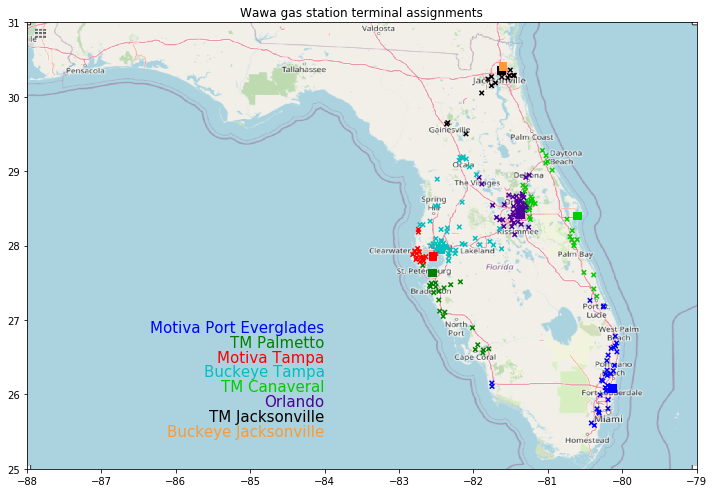

In [20]:
# extract model solution data and display on a map

# extract terminal assignment table
DFTerminalAssignment = pd.DataFrame()

for n in N:
    for m in M:
        DFTerminalAssignment.at[n,m] = int(model.x[(n,m)].value) # don't convert to integer if x is continuous
        

# show the assignments on a map
# thanks to https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
StationColors=dftd.color[DFTerminalAssignment.idxmax(axis=1)] # idmax provides terminal with highest fraction, so also works if assignment not forced to binary
TerminalNames=dftd.terminalname
fig, ax = plt.subplots(figsize = (12, 9.075))# (16,12.11))
ax.scatter(dftd.longitude, dftd.latitude, zorder=1, alpha= 1, c=dftd.color, s=60,marker='s')
# annotate map with terminal colors
for m in M:
    colorT=dftd.color[m]
    nameT=TerminalNames[m]
    ax.annotate(nameT,xy=(-85,25),size=15,xycoords='data',color=colorT,xytext=(BBox[0]+4, (BBox[3]-4-m*0.2)),horizontalalignment='right', verticalalignment='top')

ax.scatter(DFstations.longitude, DFstations.latitude, zorder=1, alpha= 1, c=StationColors, s=20,marker='x')
ax.set_title('Wawa gas station terminal assignments') 
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(FLmap, zorder=0, extent = BBox, aspect= 'equal')

On the surface, nothing appears surprising in the terminal assignments...each terminal supplies the stations clustered around it.  However, the more interesting aspects of the solution lie at the boundaries between the tributary areas for each terminal.<br><br>
For example, you can see a band of stations just east of Orlando supplied out of Canaveral and not out of Orlando.  As you will see shortly, supply from Orlando terminal is at max capacity in this solution, hence some stations are supplied from Canaveral that could be supplied at lower cost from Orlando if the maximum supply available from Orlando could be increased.<br><br>
You can also see that no stations are supplied by Buckeye Jacksonville, despite at least one Jacksonville station being closer to Buckeye than to TM.  Recall we set a minimum threshold of 500 thousand gallons/month from each station; this minimum offtake forces supply to this station to come from TM.<br><br>
Let's now roll up the data from each terminal and tabulate:

In [21]:
# compute costs per station
OptTimeCost=TimeCost*DFTerminalAssignment
OptMileageCost=MileageCost*DFTerminalAssignment
OptTruckCost=TruckCost*DFTerminalAssignment
OptTotalCost=TotalCost*DFTerminalAssignment
OptSupplyCost=SupplyCost*DFTerminalAssignment
# compute trucks required
OptTruckReq=TripHours*DFTerminalAssignment/TruckHours

OutputTable=DFTerminalAssignment.idxmax(axis=1).to_frame(name="Terminal")
OutputTable['Demand,kgal']=dfdemandsarray.max(axis=1)/1000
OutputTable['# Trucks']=OptTruckReq.sum(axis=1)
OutputTable['Time Cost']=OptTimeCost.sum(axis=1)
OutputTable['Mileage Cost']=OptMileageCost.sum(axis=1)
OutputTable['Truck Cost']=OptTruckCost.sum(axis=1)
OutputTable['Supply Cost']=OptSupplyCost.sum(axis=1)
OutputTable['Total Cost']=OptTotalCost.sum(axis=1)
OT=OutputTable
Totals=(OutputTable.sum(axis=0).to_frame(name="Totals")).transpose()
OutputTable=OutputTable.append(Totals)

#OutputTerminalTable=DFterminals[0].to_frame(name="Terminal")
OutputTerminalTable=dftd.terminalname.to_frame(name="Terminal")
OutputTerminalTable['# Trucks']=OptTruckReq.sum(axis=0)
OutputTerminalTable['Terminal Demand kgal']=(dfdemandsarray*DFTerminalAssignment).sum(axis=0)/1000
OutputTerminalTable['Terminal Capacity kgal']=dftd.capacity/1000
OutputTerminalTable['Min. Offtake kgal']=dftd.Tmin/1000
OutputTerminalTable['# Stations Supplied']=DFTerminalAssignment.sum(axis=0)
OutputTerminalTable['# Trips']=(TruckLoads*DFTerminalAssignment).sum(axis=0)
OutputTerminalTable['Supply Cost']=dftd.supplycost
OutputTerminalTable['Extra Time']=dftd.extratime

# display summary of deliveries by terminal
OutputTerminalTable.style.format({'# Trips':"{:.1f}",'# Trucks':"{:.2f}",'Terminal Demand kgal':"{:,.0f}"})\
    .hide_index()\
    .set_properties(**{'text-align': 'mid'})\
    .bar(subset=['# Trucks'], color='lightgreen',align='zero')\
    .bar(subset=['# Trips'], color='yellow',align='zero')\
    .bar(subset=['Terminal Capacity kgal'], color='lightgray',align='zero')\
    .bar(subset=['Terminal Demand kgal'], color='orange',align='zero')\
    .bar(subset=['# Stations Supplied'], color='lightblue',align='zero')

Terminal,# Trucks,Terminal Demand kgal,Terminal Capacity kgal,Min. Offtake kgal,# Stations Supplied,# Trips,Supply Cost,Extra Time
Motiva Port Everglades,2.14,"4,898",7000,500,33,445.3,0,60
TM Palmetto,1.43,"3,119",7000,500,21,283.6,0,60
Motiva Tampa,0.88,"2,408",7000,500,18,218.9,0,60
Buckeye Tampa,2.94,"6,983",7000,500,47,634.8,0,60
TM Canaveral,2.54,"4,881",7000,500,31,443.8,0,60
Orlando,2.27,"6,997",7000,500,48,636.1,0,60
TM Jacksonville,0.86,"2,048",7000,500,14,186.2,0,60
Buckeye Jacksonville,0.00,0,7000,500,0,0.0,0,60


As suggested above, Orlando is supplying at maximum capacity, as is Buckeye Tampa.  You will note that the supply from each is actualy slightly less than the 7000 kgal/month capacity; this is becasue we forced terminal assignments to be binary (all supply to a station must come from a single terminal).<br><br>
Let's roll up all of the data to see the total costs across all stations and terminals: 

In [22]:
# show overall solution summary including total cost
(OutputTable.loc['Totals'])[1:8].to_frame().style

,Totals
"Demand,kgal",31334.8
# Trucks,13.0662
Time Cost,529180
Mileage Cost,388754
Truck Cost,52264.7
Supply Cost,0
Total Cost,970199


Finally, we can view the cost and assignment data for each station.  To do so, uncomment the below line of code (it will generate a long table with a row for each station). 

In [23]:
# show details for each station supplied (long list, un-comment to see)
#OutputTable.style.format({'# Trucks':"{:.3f}",'Demand,kgal':"{:.0f}",'Terminal Demand kgal':"{:,.0f}"}) # display solution by station

Now that we have formulated the problem, we can ask no end of "what-if" questions by modifying the input data, and rerunning the steps above (run all cells).  Some examples:
<ul>
<li>What happens if maximum capacity at Orlando is increased from 7,000 kgal/month to 11,000 kgal/mo?  Would you pay an extra 0.3 cents per gallon for supply out of Orlando to get this increase in supply?  Would you pay an extra 1 cent per gallon?</li>
<li>What happens if there is a construction project at Buckeye Tampa which is expected to add 30 minute delay to all truckloads out of the terminal?</li>
<li>What happens to the aggregate demand from TM Canaveral if supply there can be had at a 1 cent per gallon discount compared to the other terminals?  Does this make Orlando terminal unconstrained?  If not, why not?</li>
<li>What happens if the minimum threshold at Buckeye Jacksonville is reduced from 500 kgal/month to 150 kgal/month?</li>
<li>What happens if the cost per hour increases from 75/hour to 100/hour?  Does this merely change the total cost to deliver, or does it change any terminal assignments?  Why? </li>
    <li>What happens if extended maintenance at Port Everglades reduces available capacity from 7000 kgal/month to 4000 kgal/month?</li>

Finally, we should acknowledge the presence of some simplifying assumptions in our model formulation, including:
<ul>
<li> All fuel demand has been aggregated as a single gasoline product, whereas in reality there would noramlly be 2 or 3 products delivered to each station: regular, premium (high octane), and, for at least some stations, diesel.  The relative demand for each would be expected to vary somewhat from station to station.</li>
    <li>We allowed for a fractional number of trucks assigned to each terminal.  One could also consider the case where you would need to pay for an integer number of trucks at each terminal.
 